# MNIST Basics

In [26]:
from fastai2.vision.all import *

In [27]:
path = untar_data(URLs.MNIST_SAMPLE)

In [28]:
path.ls()

(#3) [Path('C:/Users/Archel/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/Archel/.fastai/data/mnist_sample/train'),Path('C:/Users/Archel/.fastai/data/mnist_sample/valid')]

In [29]:
(path/'train').ls()

(#2) [Path('C:/Users/Archel/.fastai/data/mnist_sample/train/3'),Path('C:/Users/Archel/.fastai/data/mnist_sample/train/7')]

In [30]:
threes = (path/'train'/'3').ls()
sevens = (path/'train'/'7').ls()

In [31]:
im3_path = threes[0]
im3 = Image.open(im3_path)
im3

In [32]:
array(im3)[4:10, 4:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=uint8)

In [33]:
tensor(im3)[4:10, 4:10]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [34]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0,0
1,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0,0
2,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0,0
3,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0,0
4,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0,0
5,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0,0
6,0,0,0,0,0,0,0,0,0,24,209,254,254,254,171,0,0,0
7,0,0,0,0,0,0,0,0,91,137,253,254,254,254,112,0,0,0
8,0,0,0,0,0,0,40,214,250,254,254,254,254,254,34,0,0,0
9,0,0,0,0,0,0,81,247,254,254,254,254,254,254,146,0,0,0


## Pixel Similarity

In [35]:
three_tensors = [tensor(Image.open(f)) for f in threes]
seven_tensors = [tensor(Image.open(f)) for f in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

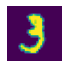

In [36]:
show_image(three_tensors[0])

In [38]:
stacked_threes = torch.stack(three_tensors).float()/255.
stacked_sevens = torch.stack(seven_tensors).float()/255.

In [40]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [44]:
stacked_threes.ndim, stacked_threes.ndim == len(stacked_threes.shape)

(3, True)

<AxesSubplot:>

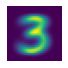

In [50]:
mean_3 = stacked_threes.mean(0)
show_image(mean_3)

<AxesSubplot:>

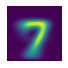

In [51]:
mean_7 = stacked_sevens.mean(0)
show_image(mean_7)

<AxesSubplot:>

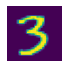

In [53]:
a_3 = stacked_threes[1]
show_image(a_3)

In [59]:
# MAE (Mean Absolute Error)
dist_3_abs = (a_3 - mean_3).abs().mean()
# RMSE (Root Mean Squared Error)
dist_3_sqr = ((a_3 - mean_3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [58]:
# MAE (Mean Absolute Error)
dist_7_abs = (a_3 - mean_7).abs().mean()
# RMSE (Root Mean Squared Error)
dist_7_sqr = ((a_3 - mean_7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [61]:
# or use F.l1_loss
F.l1_loss(a_3, mean_3), F.l1_loss(a_3, mean_7)

(tensor(0.1114), tensor(0.1586))

In [66]:
# validation set
valid_3_t = torch.stack([tensor(Image.open(f)) for f in (path/'valid'/'3').ls()])
valid_3_t = valid_3_t / 255.
valid_7_t = torch.stack([tensor(Image.open(f)) for f in (path/'valid'/'7').ls()])
valid_7_t = valid_7_t / 255.
valid_3_t.shape, valid_7_t.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [73]:
def mnist_distance(a, b):
#     return F.l1_loss(a, b)
    return (a-b).abs().mean((-1,-2))

In [74]:
mnist_distance(a_3, mean_3)

tensor(0.1114)

In [76]:
valid_3_dist = mnist_distance(valid_3_t, mean_3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [85]:
def is_3(x):
    return mnist_distance(x, mean_3) < mnist_distance(x, mean_7)

In [86]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [87]:
is_3(valid_3_t)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [88]:
accuracy_3 = is_3(valid_3_t).float().mean()
accuracy_7 = 1 - is_3(valid_7_t).float().mean()
accuracy_3, accuracy_7, (accuracy_3+accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))